Smoothing spectra is useful and important, but you have to be careful not to create new (false) information.

This notebook will show what I mean.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel

Let's generate some synthetic data--a spectrum from -50 km/s to +50 km/s at 0.5 km/s resolution with a Gaussian component centered at 0 km/s with amplitude 1 and FWHM 2 km/s

In [2]:
dv = 0.5
xvals = np.arange(-50,50.5,dv)
spect = np.random.normal(0,0.1,len(xvals)) + np.exp(-4*np.log(2)*(xvals)**2/2**2)

Now smooth by 4 channels

In [3]:
box_kernel = Box1DKernel(4)
smoothed_spect = convolve(spect, box_kernel)

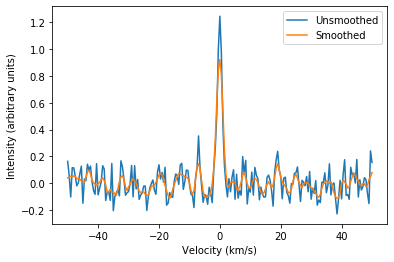

In [4]:
plt.plot(xvals,spect,label='Unsmoothed')
plt.plot(xvals,smoothed_spect,label='Smoothed')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (arbitrary units)')
plt.legend()
plt.show()

Now let's calculate the integrated intensity for both cases

In [5]:
integral_spect = np.sum(spect*dv)
integral_smoothed_spect = np.sum(smoothed_spect*dv)
print('Integrated intensity of unsmoothed line:{:5.2f}'.format(integral_spect))
print('Integrated intensity of  smoothed  line:{:5.2f}'.format(integral_smoothed_spect))

Integrated intensity of unsmoothed line: 1.95
Integrated intensity of  smoothed  line: 1.87


Ok, those look pretty similar.

Now let's get the uncertainty (let's take the uncertainty in each channel as the standard deviation in the first 50 channels, which are line-free)

In [6]:
std_spect = np.std(spect[0:50])
std_smoothed_spect = np.std(smoothed_spect[0:50])

In [7]:
spect_error = np.zeros(len(spect)) + std_spect
smoothed_spect_error = np.zeros(len(smoothed_spect)) + std_smoothed_spect

Now get the error in each integral by summing the errors in quadrature. Then calculate the significance of each detection

In [8]:
integral_spect_error = np.sqrt(np.sum(spect_error**2))*dv
integral_smoothed_spect_error = np.sqrt(np.sum(smoothed_spect_error**2))*dv

In [9]:
print('Signal to noise of unsmoothed integral:{:5.2f}'.format(integral_spect/integral_spect_error))
print('Signal to noise of  smoothed  integral:{:5.2f}'.format(integral_smoothed_spect/integral_smoothed_spect_error))

Signal to noise of unsmoothed integral: 2.77
Signal to noise of  smoothed  integral: 5.76


Somehow, we've gotten more information than we originally had... This isn't right

Let's do things right now. Before, we smoothed by a factor of 4... but we kept the same number of channels. Now, we should adjust our array so we keep only every 4th channel

In [10]:
smoothed_decimated_spect = smoothed_spect[::4]
decimated_xvals = xvals[::4] 
decimated_dv = dv * 4

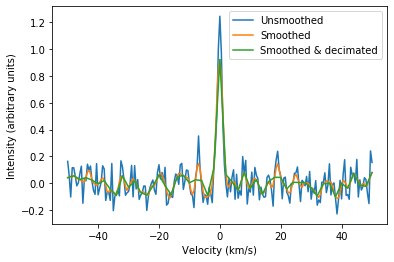

In [11]:
plt.plot(xvals,spect,label='Unsmoothed')
plt.plot(xvals,smoothed_spect,label='Smoothed')
plt.plot(decimated_xvals,smoothed_decimated_spect,label='Smoothed & decimated')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (arbitrary units)')
plt.legend()
plt.show()

In [12]:
std_smoothed_decimated_spect = np.std(smoothed_decimated_spect[0:20]) # note we've changed the range of x values to avoid emission
smoothed_decimated_spect_error = np.zeros(len(smoothed_decimated_spect)) + std_smoothed_decimated_spect

integral_smoothed_decimated_spect = np.sum(smoothed_decimated_spect*decimated_dv)
integral_smoothed_decimated_spect_error = np.sqrt(np.sum(smoothed_decimated_spect_error**2))*decimated_dv

In [13]:
print('Signal to noise of      unsmoothed      integral:{:5.2f}'.format(integral_spect/integral_spect_error))
print('Signal to noise of       smoothed       integral:{:5.2f}'.format(integral_smoothed_spect/integral_smoothed_spect_error))
print('Signal to noise of smoothed & decimated integral:{:5.2f}'.format(integral_smoothed_decimated_spect/integral_smoothed_decimated_spect_error))

Signal to noise of      unsmoothed      integral: 2.77
Signal to noise of       smoothed       integral: 5.76
Signal to noise of smoothed & decimated integral: 2.65


Note that we now have detected the line at (roughly) the same signal to noise as in the original spectrum. THIS is what we want. We can't get new information from smoothing. So, in order to use the information that's actually in our spectrum, you need to make sure that, after smoothing you update the size of the array. In some places, this is called 'decimating' the data (which explains the variable names above). A simple example of how to do your smoothing is below:

In [14]:
# Start with your data. Here I'm creating data, but usually this information will come from a FITS file
xvals = np.arange(-50,50.5,dv)
spect = np.random.normal(0,0.1,len(xvals)) + np.exp(-4*np.log(2)*(xvals)**2/2**2)

# Set up the smoothing. 
nchan = 4 # how many channels to smooth by--set by you, this values depends on your data
box_kernel = Box1DKernel(nchan)
# Now do the smoothing
spect = convolve(spect, box_kernel) # Here I overwrite the spectrum for convenience.

# The spectrum is smoothed, but we need to change the array size (both x and y) to preserve our data
# Here I overwrite the old arrays. You can create new arrays if you prefer
spect = spect[::4]
xvals = xvals[::4]